# Predictive Analytics

### Predicting future bikesharing demand

Accurately predicting future demand is an important step towards providing a high service level (e.g. by deploying additional bikes or by re-positioning vehicles etc.)

Future demand is a key factor that will steer operational decision making of a shared rental network. As a data scientist it is your responsibility to facilitate this type of decision support. For the purpose of this assignment we will be interested in forecasting total system-level demand in the next hour. To do so, develop a prediction model that predicts bike rental demand as a function of suitable features available in or derived from the datasets (incl. the weather data). <br>
– Feature Engineering: Develop a rich set of features that you expect to be correlated with your target. In this process you can draw on your domain knowledge and/or conduct additional research around the topic of demand prediction in vehicle rental networks. Justify your selection of features. <br>
– Model Building: Select three regression algorithms that are suitable for the prediction task at hand. Explain and justify why you selected the three algorithms and describe their respective advantages and drawbacks. <br>
– Model Evaluation: How well do the models perform? Evaluate and benchmark your models’ performance using suitable evaluation metrics. Which model would you select for deployment? <br>
– Outlook: How could the selected model be improved further? Explain some of the improvement levers that you might focus on in a follow-up project. <br>

## Feature Engineering

Develop a rich set of features that you expect to be correlated with your target. In this process you can draw on your domain knowledge and/or conduct additional research around the topic of demand prediction in vehicle rental networks. Justify your selection of features.

In [113]:
#Import Dataset 
#Look at Dataset / clean
#split Dataset
#Justify by showing correlation 
#maybe PCA

In [114]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import date, time, datetime, timedelta 

In [115]:
#Import Dataset 
file_path = "./data/"

raw_data = pd.read_csv(f"{file_path}chicago_2017_prepared.csv")
raw_data.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_hour,start_day,start_month,start_weekday,max_temp,min_temp,precip,start_lat,start_long,end_lat,end_long
0,2017-01-01 00:00:36,2017-01-01 00:06:32,414,191,Canal St & Taylor St,Canal St & Monroe St (*),2511,Customer,0,1,1,6,-0.6,-0.6,0.0,41.870257,-87.639474,41.880884,-87.639525
1,2017-01-01 00:02:54,2017-01-01 00:08:21,28,20,Larrabee St & Menomonee St,Sheffield Ave & Kingsbury St,3660,Subscriber,0,1,1,6,-0.6,-0.6,0.0,41.914680,-87.643320,41.910522,-87.653106
2,2017-01-01 00:06:06,2017-01-01 00:18:31,620,333,Orleans St & Chestnut St (NEXT Apts),Ashland Ave & Blackhawk St,4992,Subscriber,0,1,1,6,-0.6,-0.6,0.0,41.898203,-87.637536,41.907066,-87.667252
3,2017-01-01 00:07:28,2017-01-01 00:12:51,287,68,Franklin St & Monroe St,Clinton St & Tilden St,5637,Subscriber,0,1,1,6,-0.6,-0.6,0.0,41.880317,-87.635185,41.875885,-87.640795
4,2017-01-01 00:07:57,2017-01-01 00:20:53,300,118,Broadway & Barry Ave,Sedgwick St & North Ave,2209,Subscriber,0,1,1,6,-0.6,-0.6,0.0,41.937725,-87.644095,41.911386,-87.638677


In [116]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828954 entries, 0 to 3828953
Data columns (total 19 columns):
 #   Column              Dtype  
---  ------              -----  
 0   start_time          object 
 1   end_time            object 
 2   start_station_id    int64  
 3   end_station_id      int64  
 4   start_station_name  object 
 5   end_station_name    object 
 6   bike_id             int64  
 7   user_type           object 
 8   start_hour          int64  
 9   start_day           int64  
 10  start_month         int64  
 11  start_weekday       int64  
 12  max_temp            float64
 13  min_temp            float64
 14  precip              float64
 15  start_lat           float64
 16  start_long          float64
 17  end_lat             float64
 18  end_long            float64
dtypes: float64(7), int64(7), object(5)
memory usage: 555.0+ MB


Our task is to predict the trip demand in the next hour in the network. To do so, we decided to fit the data into a format where one data sample (one row) contains measurements on the following features:

month
day
hour
weekday
maximum temperature
precipitation

The target would then be the number of trips within that hour.

In [117]:
raw_data = raw_data[["start_month", "start_day", "start_hour", "start_weekday", "bike_id", "max_temp", "min_temp", "precip"]]
raw_data.rename(columns={"start_month": "month", "start_day": "day", "start_hour": "hour", "start_weekday": "weekday"}, inplace=True)
trip_number = raw_data.groupby(["month", "day", "hour"])['bike_id'].count()

raw_data['temp'] = raw_data['min_temp'] + ((raw_data['max_temp'] - raw_data['min_temp']) /2)
raw_data.drop(['max_temp', 'min_temp'], axis=1, inplace=True)

raw_data.drop('bike_id', axis=1, inplace=True)
raw_data.drop_duplicates(inplace=True)
raw_data['trips'] = trip_number.values
raw_data = raw_data.reset_index(drop=True)

raw_data.head()

,month,day,hour,weekday,precip,temp,trips
0,1,1,0,6,0.0,-0.6,46
1,1,1,1,6,0.0,-2.2,46
2,1,1,2,6,0.0,-2.8,36
3,1,1,3,6,0.0,-3.3,18
4,1,1,4,6,0.0,-3.3,6


In [118]:
raw_data['trips'].count()

8743

As we can see, we only have trip data for 8743 hours of the year. A year has 365 * 24 = 8760 hours. So there were 17 hours in the year were we are missing trip data, most likely because there simply were no trips during these hours. We will look look at these missing hours after creating a new data frame implementing all hours and merging both dataframes

In [119]:
hourly_2017 = (datetime(year=2017, month=1, day=1, hour=0)) + pd.to_timedelta(np.arange(365 * 24), 'H')

hourly_2017_df = pd.DataFrame(hourly_2017)
hourly_2017_df[0] = pd.to_datetime(hourly_2017_df[0])
hourly_2017_df["month"] = hourly_2017_df[0].apply(lambda date: date.month)
hourly_2017_df["day"] = hourly_2017_df[0].apply(lambda date: date.day)
hourly_2017_df["hour"] = hourly_2017_df[0].apply(lambda date: date.hour)
hourly_2017_df["weekday"] = hourly_2017_df[0].apply(lambda date: date.weekday())
hourly_2017_df = hourly_2017_df.drop(0, 1)

hourly_bikesharing_demand = pd.merge(hourly_2017_df, raw_data, on=['month', 'day', 'hour', 'hour' , 'weekday'], how='left')
#hourly_bikesharing_demand['trip_count'] = hourly_bikesharing_demand['trip_count'].fillna(0)
#hourly_bikesharing_demand['trip_count'].count()

In [120]:
hourly_bikesharing_demand.head()

,month,day,hour,weekday,precip,temp,trips
0,1,1,0,6,0.0,-0.6,46.0
1,1,1,1,6,0.0,-2.2,46.0
2,1,1,2,6,0.0,-2.8,36.0
3,1,1,3,6,0.0,-3.3,18.0
4,1,1,4,6,0.0,-3.3,6.0


In [121]:
hourly_bikesharing_demand[hourly_bikesharing_demand["trips"].isnull() == True]

,month,day,hour,weekday,precip,temp,trips
195,1,9,3,0,NaN,NaN,NaN
387,1,17,3,1,NaN,NaN,NaN
938,2,9,2,3,NaN,NaN,NaN
963,2,10,3,4,NaN,NaN,NaN
1562,3,7,2,1,NaN,NaN,NaN
1682,3,12,2,6,NaN,NaN,NaN
2114,3,30,2,3,NaN,NaN,NaN
8472,12,20,0,2,NaN,NaN,NaN
8473,12,20,1,2,NaN,NaN,NaN
8474,12,20,2,2,NaN,NaN,NaN


These 17 missing values will be filled with 0 since there were no trips and the missing weather data will be filled forward filled just like in the data preperation

In [122]:
hourly_bikesharing_demand['trips'] = hourly_bikesharing_demand['trips'].fillna(0)
hourly_bikesharing_demand = hourly_bikesharing_demand.fillna(method='ffill')
hourly_bikesharing_demand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   month    8760 non-null   int64  
 1   day      8760 non-null   int64  
 2   hour     8760 non-null   int64  
 3   weekday  8760 non-null   int64  
 4   precip   8760 non-null   float64
 5   temp     8760 non-null   float64
 6   trips    8760 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 547.5 KB


Our precipitation, trip count as well as weekday features are in float, while they should simply be an int (0 or 1).

In [123]:
hourly_bikesharing_demand['precip'] = hourly_bikesharing_demand['precip'].apply(lambda precip: int(precip))
hourly_bikesharing_demand['trips'] = hourly_bikesharing_demand['trips'].apply(lambda count: int(count))
hourly_bikesharing_demand

,month,day,hour,weekday,precip,temp,trips
0,1,1,0,6,0,-0.6,46
1,1,1,1,6,0,-2.2,46
2,1,1,2,6,0,-2.8,36
3,1,1,3,6,0,-3.3,18
4,1,1,4,6,0,-3.3,6
...,...,...,...,...,...,...,...
8755,12,31,19,6,0,-11.1,20
8756,12,31,20,6,0,-10.6,20
8757,12,31,21,6,0,-10.6,13
8758,12,31,22,6,0,-11.7,9


Before we can proceed with our predictive machine learning algorithm, we still have some things to do. First, we need to normalize the trip count and max temp features. Secondly, we need to get the dummy variables for the weekday, month, and hour features. Also we will drop the day column since it will not help explain variance

In [125]:
from sklearn.preprocessing import StandardScaler

norm = StandardScaler()
hourly_bikesharing_demand['trips_norm'] = norm.fit_transform(hourly_bikesharing_demand["trips"].values.reshape(-1, 1))
hourly_bikesharing_demand['temp_norm'] = norm.fit_transform(hourly_bikesharing_demand["temp"].values.reshape(-1, 1))

In [126]:
def weekend_(x):
    if x >= 5:
        return '1'
    else:
        return '0'

Now we can proceed with generating the dummy variables for the hour, month, and weekday features.

In [127]:
hourly_bikesharing_demand['weekend'] = hourly_bikesharing_demand['weekday'].apply(weekend_)

#hourly_bikesharing_demand = pd.get_dummies(hourly_bikesharing_demand, columns=['weekday'])
#hourly_bikesharing_demand = pd.get_dummies(hourly_bikesharing_demand, columns=['month'])
hourly_bikesharing_demand['month_norm'] = norm.fit_transform(hourly_bikesharing_demand["month"].values.reshape(-1, 1))
#hourly_bikesharing_demand = pd.get_dummies(hourly_bikesharing_demand, columns=['hour'])
hourly_bikesharing_demand['hour_norm'] = norm.fit_transform(hourly_bikesharing_demand["hour"].values.reshape(-1, 1))

In [128]:
#vis_df = hourly_bikesharing_demand[['trips', 'temp', 'precip', 'hour', 'weekday', 'month']]
hourly_bikesharing_demand.drop(['day', 'weekday'], axis=1, inplace=True)
#hourly_bikesharing_demand.drop(['day'], axis=1, inplace=True)

In [129]:
"""
import matplotlib.pyplot as plt
import seaborn as sns

f, axes = plt.subplots(1, 2, sharey = False, figsize = (16, 10))

sns.scatterplot(data = vis_df, x = 'temp', y = 'trips', ax = axes[0], hue = 'month', palette = "deep")
sns.boxplot(data = vis_df, x = 'precip', y = 'trips', ax = axes[1])

axes[0].set_xlabel("temp")
axes[0].set_ylabel("trips")

axes[1].set_xlabel("precip")
axes[1].set_ylabel("trips")
"""

'\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nf, axes = plt.subplots(1, 2, sharey = False, figsize = (16, 10))\n\nsns.scatterplot(data = vis_df, x = \'temp\', y = \'trips\', ax = axes[0], hue = \'month\', palette = "deep")\nsns.boxplot(data = vis_df, x = \'precip\', y = \'trips\', ax = axes[1])\n\naxes[0].set_xlabel("temp")\naxes[0].set_ylabel("trips")\n\naxes[1].set_xlabel("precip")\naxes[1].set_ylabel("trips")\n'

In [130]:
"""
f, axes = plt.subplots(1, 2, sharey = False, figsize = (16, 10))

sns.boxplot(data = vis_df, x = 'hour', y = 'trips', ax = axes[0])
sns.boxplot(data = vis_df, x = 'weekday', y = 'trips', ax = axes[1])

axes[0].set_xlabel("hour")
axes[0].set_ylabel("trips")

axes[1].set_xlabel("weekday")
axes[1].set_ylabel("trips")
"""

'\nf, axes = plt.subplots(1, 2, sharey = False, figsize = (16, 10))\n\nsns.boxplot(data = vis_df, x = \'hour\', y = \'trips\', ax = axes[0])\nsns.boxplot(data = vis_df, x = \'weekday\', y = \'trips\', ax = axes[1])\n\naxes[0].set_xlabel("hour")\naxes[0].set_ylabel("trips")\n\naxes[1].set_xlabel("weekday")\naxes[1].set_ylabel("trips")\n'

In [131]:
"""
f, axes = plt.subplots(1, 1, sharey = False, figsize = (16, 10))

sns.boxplot(data = vis_df, x = 'month', y = 'trips')

axes.set_xlabel("month")
axes.set_ylabel("trips")
"""

'\nf, axes = plt.subplots(1, 1, sharey = False, figsize = (16, 10))\n\nsns.boxplot(data = vis_df, x = \'month\', y = \'trips\')\n\naxes.set_xlabel("month")\naxes.set_ylabel("trips")\n'

## Model Building

Select three regression algorithms that are suitable for the prediction task at hand. Explain and justify why you selected the three algorithms and describe their respective advantages and drawbacks.

In [132]:
from sklearn.model_selection import train_test_split

X = hourly_bikesharing_demand[['temp_norm', 'precip', 'weekend', 'month_norm', 'hour_norm']]
y = hourly_bikesharing_demand['trips_norm'].values.reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y,
    test_size=0.5, shuffle = True, random_state = 8)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp,
    test_size=0.4, shuffle = True, random_state = 8) # 0,4 * 0,5 = 0,2

print('Size of training data set: ' + str(len(X_train)))
print('Size of validation data set: ' + str(len(X_validation)))
print('Size of test data set: ' + str(len(X_test)))

Size of training data set: 4380
Size of validation data set: 2628
Size of test data set: 1752


In [133]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge

def ridge_reg(features, target, regularization_param):
    model_L2 = Ridge(alpha = regularization_param, normalize = True, solver = 'lsqr')
    model_L2.fit(features, target)

    training_predictions = model_L2.predict(features)
    
    # ---

    MAE = mean_absolute_error(target, training_predictions)
    MSE = mean_squared_error(target, training_predictions)
    R2 = r2_score(target, training_predictions)
    
    return[model_L2, MAE, MSE, R2]



In [134]:
from sklearn.preprocessing import PolynomialFeatures

def get_poly_features_prime(features, degree):
    poly_features = PolynomialFeatures(degree = degree)
    return_features = poly_features.fit_transform(features)
    
    return return_features

def get_poly_features(features, degree):
    poly_max_temp = pd.DataFrame(get_poly_features_prime(features[['temp_norm']], degree))

    merged = pd.concat([features.reset_index(drop=True), poly_max_temp.reset_index(drop=True)], axis=1)
    merged = merged.drop(['temp_norm'], 1)
    return merged

We can now train our model with our training data. As a first estimate, we will use polynomial features of degree 10 and a regularization parameter of 0.05. 

In [135]:
X_train_poly = get_poly_features(X_train, 10)
res = ridge_reg(X_train_poly, y_train, 0.05)

print('For degree: 10, normalization parameter: 5 \n - MAE: ' + str(res[1])[:6] + ' \n - ME: ' + str(res[2])[:7] + ' \n - R^2-score: ' + str(res[3] * 100)[:7] + '%')

For degree: 10, normalization parameter: 5 
 - MAE: 0.6392 
 - ME: 0.74473 
 - R^2-score: 25.3096%


(Note that trip_count_norm is normalized. This means that the MAE and ME also return "normalized" errors.)

In [18]:
from sklearn.model_selection import train_test_split

X = hourly_bikesharing_demand[['temp_norm', 'precip', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23']]
y = hourly_bikesharing_demand['trips_norm'].values.reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y,
    test_size=0.5, shuffle = True, random_state = 8)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp,
    test_size=0.4, shuffle = True, random_state = 8) # 0,4 * 0,5 = 0,2

print('Size of training data set: ' + str(len(X_train)))
print('Size of validation data set: ' + str(len(X_validation)))
print('Size of test data set: ' + str(len(X_test)))

Size of training data set: 4380
Size of validation data set: 2628
Size of test data set: 1752


In [19]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

def mean_error(y_true, y_pred):
    # credit: https://datascience.stackexchange.com/questions/34141/mean-error-not-squared-in-scikit-learn-cross-val-score
    # assuming y and y_pred are numpy arrays
    return np.mean(y_pred - y_true)


def ridge_reg(features, target, regularization_param):
    model_L2 = Ridge(alpha = regularization_param, normalize = True, solver = 'lsqr')
    model_L2.fit(features, target)

    training_predictions = model_L2.predict(features)
    
    # ---

    MAE = mean_absolute_error(target, training_predictions)
    ME = mean_error(target, training_predictions)
    R2 = r2_score(target, training_predictions)
    
    return[model_L2, MAE, ME, R2]



In [20]:
from sklearn.preprocessing import PolynomialFeatures

def get_poly_features_prime(features, degree):
    poly_features = PolynomialFeatures(degree = degree)
    return_features = poly_features.fit_transform(features)
    
    return return_features

def get_poly_features(features, degree):
    poly_max_temp = pd.DataFrame(get_poly_features_prime(features[['temp_norm']], degree))

    merged = pd.concat([features.reset_index(drop=True), poly_max_temp.reset_index(drop=True)], axis=1)
    merged = merged.drop(['temp_norm'], 1)
    return merged

We can now train our model with our training data. As a first estimate, we will use polynomial features of degree 10 and a regularization parameter of 0.05. 

In [21]:
X_train_poly = get_poly_features(X_train, 10)
res = ridge_reg(X_train_poly, y_train, 0.05)

print('For degree: 10, normalization parameter: 5 \n - MAE: ' + str(res[1])[:6] + ' \n - ME: ' + str(res[2])[:7] + ' \n - R^2-score: ' + str(res[3] * 100)[:7] + '%')

For degree: 10, normalization parameter: 5 
 - MAE: 0.4152 
 - ME: 5.37368 
 - R^2-score: 68.0640%


(Note that trip_count_norm is normalized. This means that the MAE and ME also return "normalized" errors.)

---

### Hyperparameter Tweaking - Model 1.1 (Ridge)

Okay, now we can continue with hyperparameter tweaking. We will begin with a regularization parameter of 0, so no regularization.

In [22]:
max_degree = 50
train_res_arr = []
validation_res_arr = []

for i in range(max_degree + 1):
    X_train_poly = get_poly_features(X_train, i)
    res_train = ridge_reg(X_train_poly, y_train, 0)
    
    train_res_arr.append([i, res_train[1], res_train[2], res_train[3]])
    
    # ---
    
    X_validation_poly = get_poly_features(X_validation, i)
    predictions_validation = res_train[0].predict(X_validation_poly)
    
    MAE = mean_absolute_error(y_validation, predictions_validation)
    ME = mean_error(y_validation, predictions_validation)
    R2 = r2_score(y_validation, predictions_validation)
    
    validation_res_arr.append([i, MAE, ME, R2])
    
# ---    

train_res_arr_df = pd.DataFrame(train_res_arr)
train_res_arr_df = train_res_arr_df.rename(columns={0: "poly_degree", 1: "MAE_training", 2: "ME_training", 3: "R2_score_training"})

validation_res_arr_df = pd.DataFrame(validation_res_arr)
validation_res_arr_df = validation_res_arr_df.rename(columns={0: "poly_degree", 1: "MAE_validation", 2: "ME_validation", 3: "R2_score_validation"})

hyperparameter_tweaking_polydegr_results = pd.merge(train_res_arr_df, validation_res_arr_df, on='poly_degree', how='inner')

In [23]:
def plot_tweaking_res(data, x):
    f, axes = plt.subplots(1, 3, sharey=False, figsize=(16, 10))

    sns.lineplot(data=data, x=x, y='MAE_training', ax=axes[0], color="red")
    sns.lineplot(data=data, x=x, y='MAE_validation', ax=axes[0], color="blue")

    sns.lineplot(data=data, x=x, y='ME_training', ax=axes[1], color="red")
    sns.lineplot(data=data, x=x, y='ME_validation', ax=axes[1], color="blue")

    sns.lineplot(data=data, x=x, y='R2_score_training', ax=axes[2], color="red")
    sns.lineplot(data=data, x=x, y='R2_score_validation', ax=axes[2], color="blue")
    
    axes[0].set_xlabel(x)
    axes[0].set_ylabel("Mean Average Error")
    axes[0].set_title(x + " to MAE", fontsize=14)
    
    axes[1].set_xlabel(x)
    axes[1].set_ylabel("Mean Error")
    axes[1].set_title(x + " to ME", fontsize=14)

    axes[2].set_xlabel(x)
    axes[2].set_ylabel("R^2-score")
    axes[2].set_title(x + " to R^2-score", fontsize=14)

    print('Red: training data set \nBlue: validation data set')

Red: training data set 
Blue: validation data set


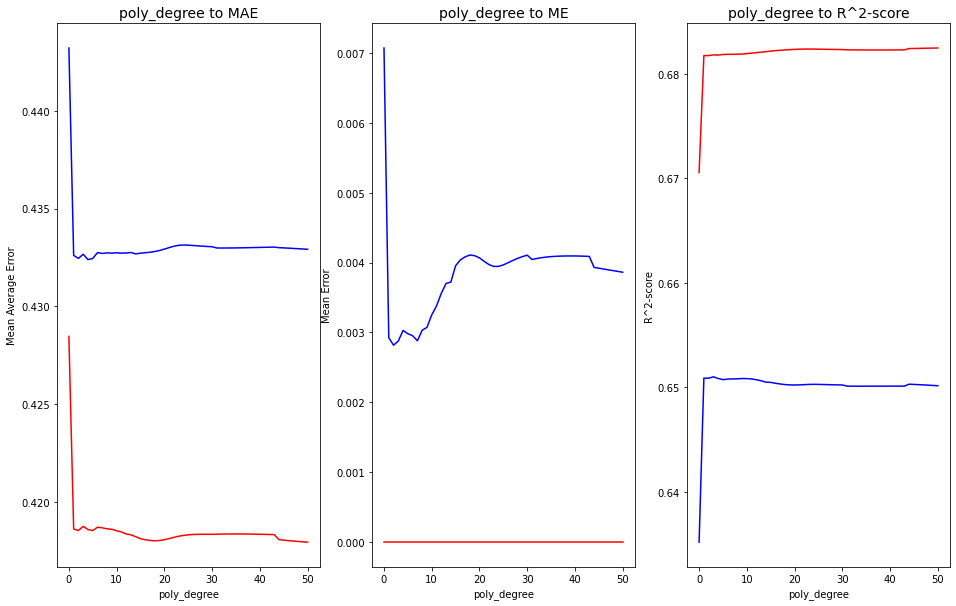

In [24]:
plot_tweaking_res(hyperparameter_tweaking_polydegr_results, 'poly_degree')

In [25]:
min_MAE_id = hyperparameter_tweaking_polydegr_results['MAE_validation'].idxmin()
hyperparameter_tweaking_polydegr_results.iloc[min_MAE_id]

poly_degree            4.000000e+00
MAE_training           4.185674e-01
ME_training           -4.461170e-18
R2_score_training      6.817749e-01
MAE_validation         4.323883e-01
ME_validation          3.028879e-03
R2_score_validation    6.508372e-01
Name: 4, dtype: float64

In [26]:
max_R2_id = hyperparameter_tweaking_polydegr_results['R2_score_validation'].idxmax()
hyperparameter_tweaking_polydegr_results.iloc[max_R2_id]

poly_degree            3.000000e+00
MAE_training           4.187330e-01
ME_training            9.733462e-18
R2_score_training      6.817967e-01
MAE_validation         4.326619e-01
ME_validation          2.877780e-03
R2_score_validation    6.509984e-01
Name: 3, dtype: float64

As can be seen by the results above, the best MAE and R^2-score in the validation data set is achieved by a polynomial of degree 40 (we will pay more attention to our MAE because we are more interested in minimizing our MAE than we are in explaining variance in the data). So let us set our optimal degree to 40 for now and tweak our regularization parameter. 

In [49]:
max_reg_param = 500
opt_degree = 40
train_res_arr = []
validation_res_arr = []

for i in range(max_reg_param + 1):
    reg_param = 0.001 * i
    
    X_train_poly = get_poly_features(X_train, opt_degree)
    res_train = ridge_reg(X_train_poly, y_train, reg_param)
    
    train_res_arr.append([reg_param, res_train[1], res_train[2], res_train[3]])
    
    # ---
    
    X_validation_poly = get_poly_features(X_validation, opt_degree)
    predictions_validation = res_train[0].predict(X_validation_poly)
    
    MAE = mean_absolute_error(y_validation, predictions_validation)
    ME = mean_error(y_validation, predictions_validation)
    R2 = r2_score(y_validation, predictions_validation)
    
    validation_res_arr.append([reg_param, MAE, ME, R2])
    
# ---    

train_res_arr_df = pd.DataFrame(train_res_arr)
train_res_arr_df = train_res_arr_df.rename(columns={0: "regularization_param", 1: "MAE_training", 2: "ME_training", 3: "R2_score_training"})

validation_res_arr_df = pd.DataFrame(validation_res_arr)
validation_res_arr_df = validation_res_arr_df.rename(columns={0: "regularization_param", 1: "MAE_validation", 2: "ME_validation", 3: "R2_score_validation"})

hyperparameter_tweaking_regparam_results = pd.merge(train_res_arr_df, validation_res_arr_df, on='regularization_param', how='inner')

Red: training data set 
Blue: validation data set


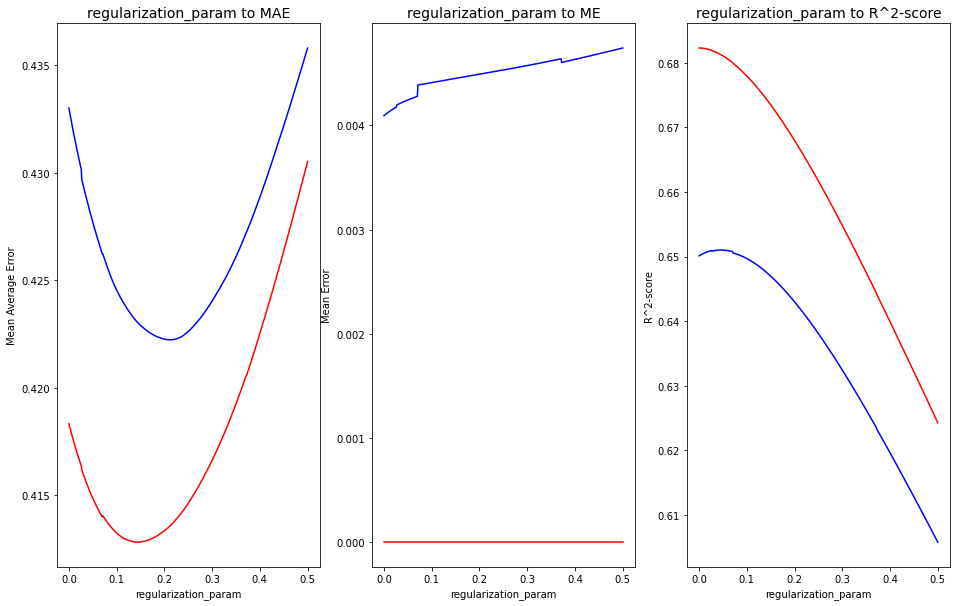

In [50]:
plot_tweaking_res(hyperparameter_tweaking_regparam_results, 'regularization_param')

In [51]:
min_MAE_id = hyperparameter_tweaking_regparam_results['MAE_validation'].idxmin()
hyperparameter_tweaking_regparam_results.iloc[min_MAE_id]

regularization_param    2.130000e-01
MAE_training            4.136015e-01
ME_training            -4.968121e-17
R2_score_training       6.663848e-01
MAE_validation          4.222294e-01
ME_validation           4.500942e-03
R2_score_validation     6.417849e-01
Name: 213, dtype: float64

In [52]:
max_R2_id = hyperparameter_tweaking_regparam_results['R2_score_validation'].idxmax()
hyperparameter_tweaking_regparam_results.iloc[max_R2_id]

regularization_param    4.600000e-02
MAE_training            4.150645e-01
ME_training             8.313999e-18
R2_score_training       6.812108e-01
MAE_validation          4.280286e-01
ME_validation           4.236469e-03
R2_score_validation     6.510002e-01
Name: 46, dtype: float64

Our optimal regularization parameter for degree 40 was 0.21 (we will pay more attention to our MAE because we are more interested in minimizing our MAE than we are in explaining variance in the data).
 
#While writing this notebook we now put our optimal regularization parameter into our polynomial degree tweaking, and then put #that new optimal polynomial degree into our regularization parameter tweaking and iterated through this process a couple of #times, until we reached equilibrium. This section is skipped here because if we would have included it, this notebook would #have gotten very long. We will however show you, that we have found our equilibrium at a regularization parameter of ? and #a polynomial degree of ?.

Red: training data set 
Blue: validation data set


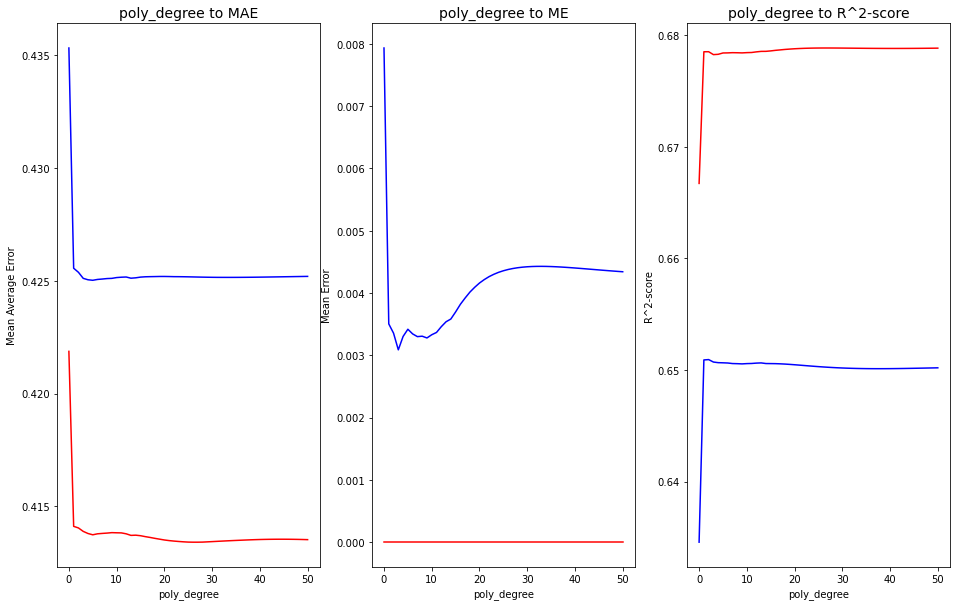

In [31]:
max_degree = 50
opt_reg_param = 0.21
train_res_arr = []
validation_res_arr = []

for i in range(max_degree + 1):
    X_train_poly = get_poly_features(X_train, i)
    res_train = ridge_reg(X_train_poly, y_train, opt_reg_param)
    
    train_res_arr.append([i, res_train[1], res_train[2], res_train[3]])
    
    # ---
    
    X_validation_poly = get_poly_features(X_validation, i)
    predictions_validation = res_train[0].predict(X_validation_poly)
    
    MAE = mean_absolute_error(y_validation, predictions_validation)
    ME = mean_error(y_validation, predictions_validation)
    R2 = r2_score(y_validation, predictions_validation)
    
    validation_res_arr.append([i, MAE, ME, R2])
    
# ---    

train_res_arr_df = pd.DataFrame(train_res_arr)
train_res_arr_df = train_res_arr_df.rename(columns={0: "poly_degree", 1: "MAE_training", 2: "ME_training", 3: "R2_score_training"})

validation_res_arr_df = pd.DataFrame(validation_res_arr)
validation_res_arr_df = validation_res_arr_df.rename(columns={0: "poly_degree", 1: "MAE_validation", 2: "ME_validation", 3: "R2_score_validation"})

hyperparameter_tweaking_polydegr_results = pd.merge(train_res_arr_df, validation_res_arr_df, on='poly_degree', how='inner')

# ---

plot_tweaking_res(hyperparameter_tweaking_polydegr_results, 'poly_degree')

In [32]:
min_MAE_id = hyperparameter_tweaking_polydegr_results['MAE_validation'].idxmin()
hyperparameter_tweaking_polydegr_results.iloc[min_MAE_id]

poly_degree            5.000000e+00
MAE_training           4.137414e-01
ME_training           -2.940317e-17
R2_score_training      6.783971e-01
MAE_validation         4.250199e-01
ME_validation          3.417943e-03
R2_score_validation    6.506368e-01
Name: 5, dtype: float64

In [33]:
max_R2_id = hyperparameter_tweaking_polydegr_results['R2_score_validation'].idxmax()
hyperparameter_tweaking_polydegr_results.iloc[max_R2_id]

poly_degree            2.000000e+00
MAE_training           4.140452e-01
ME_training           -4.400336e-17
R2_score_training      6.785098e-01
MAE_validation         4.253735e-01
ME_validation          3.355025e-03
R2_score_validation    6.509254e-01
Name: 2, dtype: float64

In [53]:
max_reg_param = 500
opt_degree = 50
train_res_arr = []
validation_res_arr = []

for i in range(max_reg_param + 1):
    reg_param = 0.001 * i
    
    X_train_poly = get_poly_features(X_train, opt_degree)
    res_train = ridge_reg(X_train_poly, y_train, reg_param)
    
    train_res_arr.append([reg_param, res_train[1], res_train[2], res_train[3]])
    
    # ---
    
    X_validation_poly = get_poly_features(X_validation, opt_degree)
    predictions_validation = res_train[0].predict(X_validation_poly)
    
    MAE = mean_absolute_error(y_validation, predictions_validation)
    ME = mean_error(y_validation, predictions_validation)
    R2 = r2_score(y_validation, predictions_validation)
    
    validation_res_arr.append([reg_param, MAE, ME, R2])
    
# ---    

train_res_arr_df = pd.DataFrame(train_res_arr)
train_res_arr_df = train_res_arr_df.rename(columns={0: "regularization_param", 1: "MAE_training", 2: "ME_training", 3: "R2_score_training"})

validation_res_arr_df = pd.DataFrame(validation_res_arr)
validation_res_arr_df = validation_res_arr_df.rename(columns={0: "regularization_param", 1: "MAE_validation", 2: "ME_validation", 3: "R2_score_validation"})

hyperparameter_tweaking_regparam_results = pd.merge(train_res_arr_df, validation_res_arr_df, on='regularization_param', how='inner')

Red: training data set 
Blue: validation data set


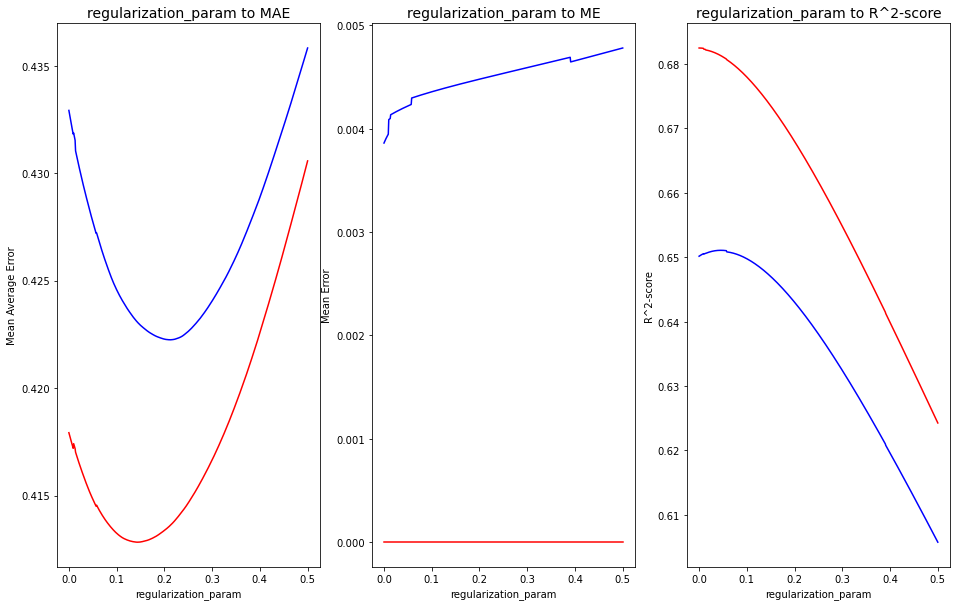

In [54]:
plot_tweaking_res(hyperparameter_tweaking_regparam_results, 'regularization_param')

In [36]:
min_MAE_id = hyperparameter_tweaking_regparam_results['MAE_validation'].idxmin()
hyperparameter_tweaking_regparam_results.iloc[min_MAE_id]

regularization_param    2.120000e-01
MAE_training            4.136694e-01
ME_training            -3.771717e-17
R2_score_training       6.662963e-01
MAE_validation          4.221708e-01
ME_validation           3.980882e-03
R2_score_validation     6.420516e-01
Name: 212, dtype: float64

In [37]:
max_R2_id = hyperparameter_tweaking_regparam_results['R2_score_validation'].idxmax()
hyperparameter_tweaking_regparam_results.iloc[max_R2_id]

regularization_param    4.100000e-02
MAE_training            4.152619e-01
ME_training             8.516779e-18
R2_score_training       6.813874e-01
MAE_validation          4.285118e-01
ME_validation           3.898383e-03
R2_score_validation     6.512527e-01
Name: 41, dtype: float64

Equilibrium was reached for optimal parameters:
- polynomial degree: 18
- regularization parameter: 0.088

---

### Performance Evaluation - Model 1.1 (Ridge)

Let us finally test our models performance with our test data set.

In [38]:
opt_degree = 18
opt_regularization = 0.088

X_train_poly = get_poly_features(X_train, opt_degree)
res_train = ridge_reg(X_train_poly, y_train, opt_regularization)
    
# ---
    
X_test_poly = get_poly_features(X_test, opt_degree)
predictions_test = res_train[0].predict(X_test_poly)
    
MAE = mean_absolute_error(y_test, predictions_test)
ME = mean_error(y_test, predictions_test)
R2 = r2_score(y_test, predictions_test)
    
std_trip_count = hourly_bikesharing_demand['trips'].std()

print('Performance on test data set:')
print('Mean absolute error: ' + str(MAE)[:6] + ' | ' + str(MAE * std_trip_count)[:6] + ' trips')
print('Mean error: ' + str(ME)[:7] + ' | ' + str(ME * std_trip_count)[:7] + ' trips')
print('R^2-score: ' + str(R2 * 100)[:7] + '%')

Performance on test data set:
Mean average error: 0.4274 | 213.01 trips
Mean error: 0.01247 | 6.21845 trips
R^2-score: 66.0820%


## Model Evaluation

How well do the models perform? Evaluate and benchmark your models’ performance using suitable evaluation metrics. Which model would you select for deployment?

## Outlook

How could the selected model be improved further? Explain some of the improvement levers that you might focus on in a follow-up project.